Get Data from URL, cleanse the data, and write data to 'lyrics.txt' file

In [14]:
import requests
from bs4 import BeautifulSoup
import re
import os
import codecs

url = 'https://stixoi.info/stixoi.php?info=Lyrics&act=index&sort=alpha&singer_id=1820'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

f = open('lyrics.txt', 'w', encoding='utf-8')
tempsoup = soup.find_all('td', class_='row1') 
for i in range(1, 622, 9):
    link = str(tempsoup[i].find('a'))
    song_id = re.search('(?<=song_id=)(.*)(?=")', link)
    song_id = song_id.group()
    song_lyrics_url = "https://stixoi.info/stixoi.php?info=Lyrics&act=details&song_id="+song_id
    page = requests.get(song_lyrics_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    lyrics = soup.find_all('div', class_='lyrics')
    lyrics = lyrics[0].get_text()
    
    #Remove empty lines from final lyrics
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
    f.write(lyrics)

f.close()

Import tensorflow libraries and numpy

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

Prepare Data

In [3]:
data = open('lyrics.txt', encoding = 'utf-8').read()
corpus = data.lower().split("\n")

tokenizer = Tokenizer() #oov_token="<OOV>"
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [11]:
#Some code for debugging 

'''
word_index = tokenizer.word_index
print(word_index)
'''

'''
print(input_sequences[3])
print(input_sequences.shape)
'''

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  1]
(8613, 18)


## Initialize NN model (for this code to run it was needed to downgrade to numpy version == 1.18.5

In [5]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(120, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(96))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 128)           288896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 17, 240)           239040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 240)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                129408    
_________________________________________________________________
dense_2 (Dense)              (None, 1128)              109416    
_________________________________________________________________
dense_3 (Dense)              (None, 2257)              2548153   
Total params: 3,314,913
Trainable params: 3,314,913
Non-trainable params: 0
____________________________________________

In [6]:
history = model.fit(predictors, label, epochs=100, verbose=1)


Epoch 1/100
270/270 [==============================] - 29s 107ms/step - loss: 6.8949 - accuracy: 0.0424
Epoch 2/100
270/270 [==============================] - 26s 97ms/step - loss: 6.2768 - accuracy: 0.0414
Epoch 3/100
270/270 [==============================] - 28s 102ms/step - loss: 6.1551 - accuracy: 0.0432s - loss: 6
Epoch 4/100
270/270 [==============================] - 25s 94ms/step - loss: 6.0116 - accuracy: 0.0482
Epoch 5/100
270/270 [==============================] - 27s 99ms/step - loss: 5.9193 - accuracy: 0.0545
Epoch 6/100
270/270 [==============================] - 25s 92ms/step - loss: 5.8464 - accuracy: 0.0598
Epoch 7/100
270/270 [==============================] - 26s 95ms/step - loss: 5.7760 - accuracy: 0.0639
Epoch 8/100
270/270 [==============================] - 22s 82ms/step - loss: 5.7145 - accuracy: 0.0687
Epoch 9/100
270/270 [==============================] - 23s 84ms/step - loss: 5.6445 - accuracy: 0.0715
Epoch 10/100
270/270 [==============================] - 23s 

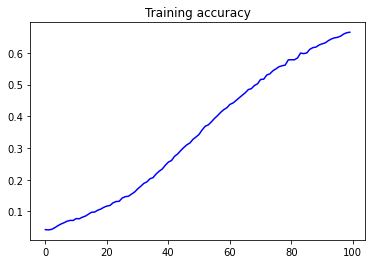

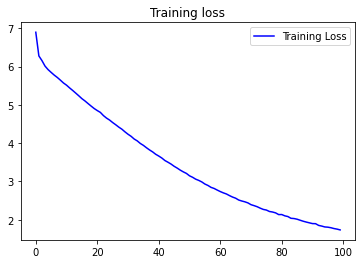

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [18]:
seed_text = "πως θες να αρχίσω τι να προσπαθήσω για μένα να πω"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

πως θες να αρχίσω τι να προσπαθήσω για μένα να πω ηττήθηκε εσύ λείπει τι δεν υπάρχει το χρονόμετρο νεκρό παν στα αισθήματα άδεια του κεφάλι πνίγοντας θέλησα τρομάζω να όνειρο θα γίνουν μια ζωή μαζί θέλησα ζημιά το χέρι σου ρώτα με φιλιά και πάλι μου όνειρά μη μη σε όνειρο φωτιά στον βυθό φωτιά θέλησα τι να μας έρωτας μου· εσύ μα πόλεμος ζάλη λύση φωτιές από ’δω σαν περνάει ένα παιχνίδι φίλε μου άλλο πράγμα τα γκρεμό σου είμαι με θέλεις να όνειρο θέλησα να μη δεις ζημιά θέλησα εγώ να με λυτρώσουνώρα γκόμενο παν στα αισθήματα άλλο να μας το μυαλό λεν’ θέλησα όλα το κεφάλι για
